In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
df = pd.read_pickle('model_df.pkl')

In [65]:
cutoff = datetime.strptime('2014-03-01','%Y-%m-%d')


In [66]:
final_GDP = df.GDP_interp.loc[df.chart_date==cutoff].values[0]
final_GDP

52642.28888888889

In [67]:

df['GDP_interp'] = df.GDP_interp.diff()
df['sentiment'] = df.sentiment.diff()

In [68]:
df['sentiment_L' + str(19)] = df.sentiment.shift(19,fill_value=0)
df.dropna(inplace=True)

In [69]:
test_df = df.loc[df.chart_date > cutoff]
train_df = df.loc[df.chart_date <= cutoff]
X_train = train_df.sentiment_L19
X_test = test_df.sentiment_L19
y_train = pd.DataFrame(train_df.GDP_interp)
y_test = pd.DataFrame(test_df.GDP_interp)

In [70]:
lags = 36 # number of lags for endogenous variable
order = ([3,6,9,12,15,18,21,24],1,[3,6,9,12,15,18,21,24])
seasonal = True
period = 4

In [71]:
model = SARIMAX(
        endog = y_train,
        lags=lags,
        exog=X_train,
        order=order,
        seasonal=seasonal,
        period=period)

c:\Users\kapta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kapta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [72]:
model_fit = model.fit(maxiter=200)

c:\Users\kapta\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [73]:
model_fit.params

sentiment_L19      57.808258
ar.L3              -0.708808
ar.L6              -0.564603
ar.L9              -0.569172
ar.L12             -0.606137
ar.L15             -0.537348
ar.L18             -0.697746
ar.L21             -0.015876
ar.L24              0.041609
ma.L3               0.088015
ma.L6               0.168846
ma.L9               0.114568
ma.L12              0.185758
ma.L15             -0.026926
ma.L18              0.338185
ma.L21             -0.654594
ma.L24             -0.323093
sigma2           2305.116032
dtype: float64

In [74]:
exog = X_test

In [75]:
pd.DataFrame(model_fit.forecasts[0],columns=['predicted_mean'])

,predicted_mean
0,0.000000
1,104.347826
2,87.271739
3,84.277013
4,94.977114
...,...
660,79.377840
661,-96.073017
662,-99.220550
663,21.218520


In [76]:
predict = model_fit.get_prediction(start = 0 ,end=len(df)-1,exog = X_test)


c:\Users\kapta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [77]:
og_df = pd.read_pickle('model_df.pkl')
og_df

,sentiment,GDP_interp,chart_date
date,,,
1958-09-01,0.169755,17381.652174,1958-09-01
1958-10-01,0.196548,17486.000000,1958-10-01
1958-11-01,0.204485,17573.271739,1958-11-01
1958-12-01,0.177540,17657.728261,1958-12-01
1959-01-01,0.186635,17745.000000,1959-01-01
...,...,...,...
2022-07-01,0.125863,60082.000000,2022-07-01
2022-08-01,0.045380,60082.000000,2022-08-01
2022-09-01,0.012304,60082.000000,2022-09-01


In [78]:
df

,sentiment,GDP_interp,chart_date,sentiment_L19
date,,,,
1958-10-01,0.026793,104.347826,1958-10-01,0.000000
1958-11-01,0.007938,87.271739,1958-11-01,0.000000
1958-12-01,-0.026945,84.456522,1958-12-01,0.000000
1959-01-01,0.009095,87.271739,1959-01-01,0.000000
1959-02-01,-0.000868,113.666667,1959-02-01,0.000000
...,...,...,...,...
2022-07-01,0.236422,107.472527,2022-07-01,0.004151
2022-08-01,-0.080484,0.000000,2022-08-01,-0.084286
2022-09-01,-0.033076,0.000000,2022-09-01,0.109437


In [79]:
og_df = pd.read_pickle('model_df.pkl')
res_df = pd.concat([pd.DataFrame(X_train),pd.DataFrame(X_test)])
res_df['predict_GDP'] = predict.predicted_mean.values
confidence = predict.conf_int()
confidence.set_index(res_df.index,inplace=True)
res_df = pd.concat([res_df,confidence],axis=1)
act_df = og_df
res_df = pd.concat([res_df,act_df],axis=1)
#res_df['GDP_interp'] = res_df.GDP_interp.shift(1)
#res_df.drop(index="1958-10-01")

In [80]:
res_df['sentiment_L19'] = res_df.sentiment.shift(19)

In [81]:
# res_df['predict_GDP'] = res_df.predict_GDP.shift(-1)
# res_df['lower GDP_interp'] = res_df['lower GDP_interp'].shift(-1)
# res_df['upper GDP_interp'] = res_df['upper GDP_interp'].shift(-1)

In [82]:
res_df['predict_GDP'] = res_df['predict_GDP'].cumsum() + 17381.652174

In [83]:
res_df['lower GDP_interp'] = res_df['lower GDP_interp']+res_df['predict_GDP']
res_df['upper GDP_interp'] = res_df['upper GDP_interp']+res_df['predict_GDP']

In [84]:
res_df.rename(columns={"lower GDP_interp": "continuous_low_GDP", "upper GDP_interp": "continuous_high_GDP"},inplace=True)

In [85]:
forecast = model_fit.get_forecast(len(X_test),exog = X_test)

c:\Users\kapta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [86]:
confidince = forecast.conf_int().reset_index(drop=True)

In [87]:
cast_df = pd.DataFrame(X_test)
cast_df = pd.concat([X_test.reset_index(),confidince],axis=1).set_index('date').drop(['sentiment_L19'],axis=1)


In [88]:
cast_df = pd.concat([cast_df,res_df],axis=1)

In [89]:
cast_df['lower GDP_interp'] = cast_df['lower GDP_interp'].cumsum()+52768.652524
cast_df['upper GDP_interp'] = cast_df['upper GDP_interp'].cumsum()+52768.652524

<AxesSubplot:xlabel='date'>

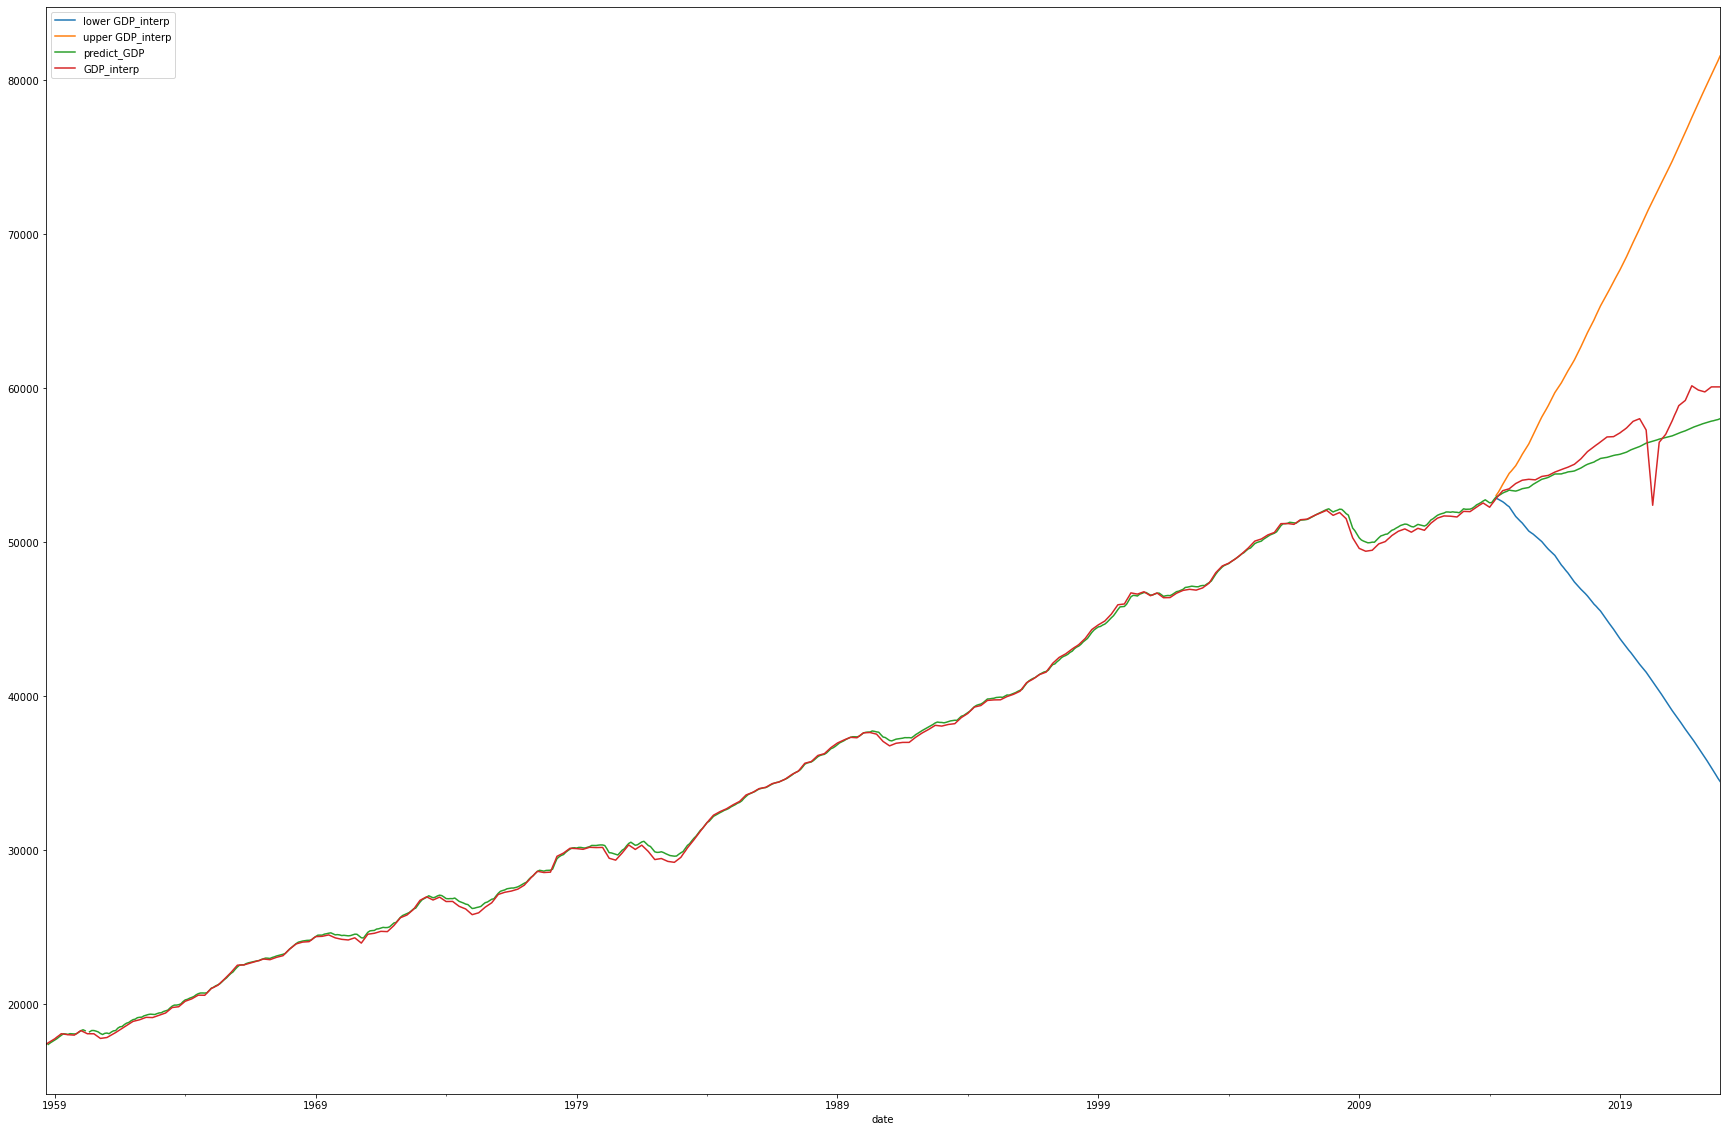

In [91]:
cast_df.drop(['sentiment_L19','sentiment','chart_date','continuous_low_GDP','continuous_high_GDP'],axis=1).plot(figsize=(30,20))

<AxesSubplot:xlabel='date'>

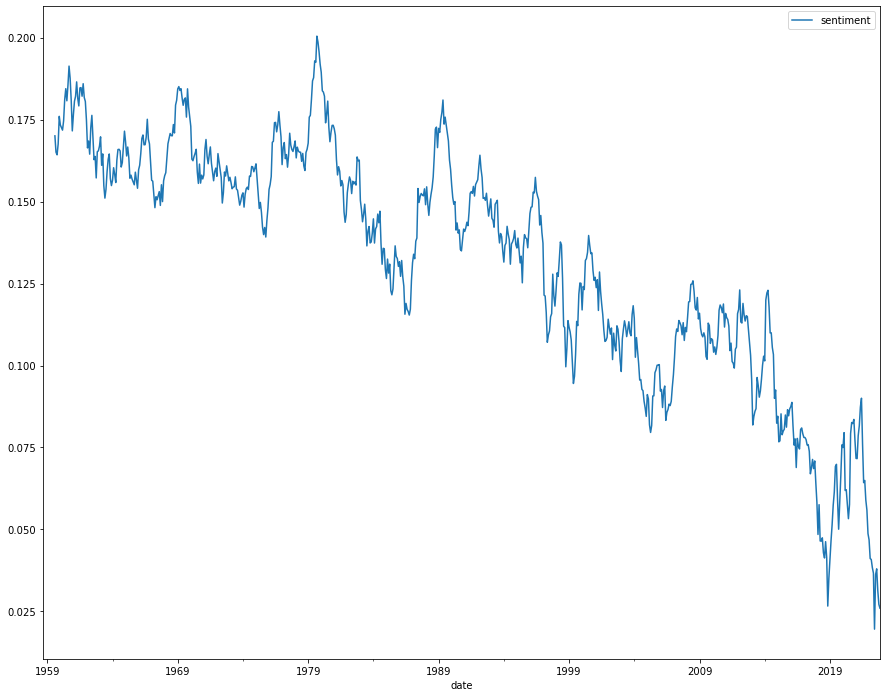

In [31]:
pd.DataFrame(res_df.sentiment).rolling(window=12).mean().plot(figsize=(15,12),use_index=True)